The first step in order to simulate thousands of different portfolio construction techniques for how to put together a goal hedging portfolio and a performance seeking portfolio is to stitch the CIR model which generates lots of different scenarios for interest rates, to feed those different interest rate scenarios through to our bond pricing and present value calculations that were done.

In [1]:
import numpy as np
import pandas as pd
import risk_kit as kit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t 
    and r is the per-period interest rate.
    Returns a |t|*|r| Series or DataFrame.
    r can be a float, Series or DataFrame.
    Returns a DataFrame indexed by t
    """
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

In [3]:
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) 
    and amounts r can be a scalar, or a Series or DataFrame with the number of rows matching
    the number of rows in flows. 
    """
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

In [4]:
# Construct a 5 year bond with face value of 100, coupon rate of 5%, 12 coupons discount rate of 3%
kit.bond_price(5, 100, .05, 12, .03)

0    109.275393
dtype: float64

109$ makes sense as the coupon is higher than my discount rate, and so the bond is selling at a premium.

In [5]:
# Get rates and 500 scenarios for zero-coupon prices for a bond with 10 year maturity, 500 scenarios
rates, zc_prices = kit.cir(10, 500, b=0.03, r_0=0.03)
# Check for time step 0 (iloc[0])
kit.bond_price(5, 100, 0.05, 12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

At time t=0, all the interest rates are the same (r_0=0) and so the bond price is exactly the same.

In [6]:
kit.bond_price(5, 100, 0.05, 12, rates.iloc[1][[1,2,3]])

1    110.669120
2    108.626259
3    108.592629
dtype: float64

In [8]:
# Why did the bond prices start to diverge at time t=1? Look at the rates used.
rates[[1,2,3]].head()

,1,2,3
0,0.030000,0.030000,0.030000
1,0.027156,0.031338,0.031408
2,0.025874,0.029883,0.031004
3,0.026365,0.027578,0.028562
4,0.026240,0.028158,0.029446


Because the interest rates moved, the bond prices moved.

In [13]:
# Include to process discount rate as a dataframe in the bond price function.
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity at which time 
    the principal and the final coupon is returned.
    This is not designed to be efficient, rather, it is to illustrate the underlying 
    principle behind bond pricing.
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon rate and 
    the bond value is computed over time.
    i.e: The index of the discount_rate DataFrame is assumed to be the coupon number.
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.iloc[t] = kit.bond_price(maturity-t/coupons_per_year, principal, coupon_rate, 
                                        coupons_per_year, discount_rate.loc[t])
        return prices
    else: # base case ...single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = kit.bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

In [17]:
# 10 year bond
prices = kit.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]])

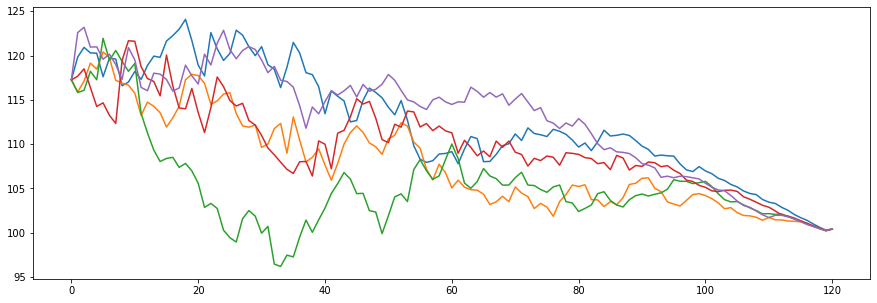

In [18]:
kit.bond_price(10, 100, 0.05, 12, rates[[1,2,3,4,5]]).plot(legend=False, figsize=(15,5))

The possible price of this bond diverges as interest rates change. 

*Why are we doing this?*

We want to generate random bond prices so that we can generate returns from these random bond prices. Once we get the returns from a bond portfolio, we can then construct the returns of a portfolio that consists of a mix of stocks and bonds.  

What do we do in order to get the returns of a bond? 

In [22]:
# To check if I can use percentage change to calculate returns
bond_returns = prices.pct_change().dropna()
kit.annualize_rets(bond_returns, 12)

1   -0.015387
2   -0.015387
3   -0.015387
4   -0.015387
5   -0.015387
dtype: float64

The above results are very strange because the above answer represents the price return. This is just the price of the bond representing the capital gain or loss of the bond. What we are interested is in the **total return** of the bond. The total return of the bond is the value that you get not just from the price appreciation or loss, but also the value of the coupons.

In [25]:
# Total return of the bond
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a bond based on monthly bond prices and coupon payments. 
    Assumes that dividends (coupons) are paid out at the end of the period (eg: end of 
    3 months for quarterly div) and that dividends are reinvested in bonds. 
    """
    coupons = pd.DataFrame(data=0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    # Space pay dates over time - monthly 
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [26]:
monthly_prices = kit.bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
bond_total_return = bond_total_return(monthly_prices, 100, .05, 12)
kit.annualize_rets(bond_total_return, 12)

1    0.029439
2     0.03133
3    0.032538
4    0.030481
dtype: object

You can see that the total returns that you get from a non-zero coupon paying bond are affected by interest rates. Because those intermediate coupons get reinvested at the then rate. The 'then rate' is a number that changes over time.I don't even know what the interest rate is going to be 5years from now or even next month. So Bond Prices change over time and are even the total return is affected by interest rates, because of those intermediate payments.

Now we can generate prices from which we can generate returns. Now, we can start experimenting across asset classes.

In [29]:
# Simple asset Class

# Assume that I have got 10 year bond
price_10 = kit.bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

,1,2,3
116,101.410585,101.027892,101.074127
117,100.991038,100.746078,100.715202
118,100.616594,100.508289,100.490175
119,100.290203,100.277121,100.225911
120,100.416667,100.416667,100.416667


At the end of the bond period, the bond price has converged to the final payment.

In [30]:
# Now construct a 30 year bond
price_30 = kit.bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()

,1,2,3
116,179.817889,152.161946,155.21817
117,172.558494,149.797916,147.193786
118,165.739882,150.974929,148.6641
119,160.354934,156.786363,143.717319
120,157.43151,161.118008,143.559163


The interest rates were generated for 10 years (CIR model ran for 10 years). The above prices are of a 30-year bond over 10 years. The prices at the end do not converge because I still have maturity left; still have 20 years to go.

In [31]:
# Look at the prices in the beginning
price_30[[1,2,3]].head()

,1,2,3
0,139.531564,139.531564,139.531564
1,146.754769,136.202284,136.035587
2,150.118331,139.685079,136.943864
3,148.69614,145.47701,142.936775
4,148.941647,143.892999,140.631117


They start out at exactly the same place. The bond prices variate in 10 years and this is why you should not use long bond as your hedge, you are not safe. You do not know the value of your portfolio 10 years from now.

In [32]:
# Compute Returns
returns_30 = kit.bond_total_return(price_30, 100, .05, 12)
returns_10 = kit.bond_total_return(price_10, 100, .05, 12)

# Construct a new bond portfolio with a 60-40 mix of the 10year and the 40year bonds. 
# I am assuming that we are re-balancing bak to 60-40 at the end of every month. 
# [That is why this works. Otherwise you would have to drift the weights over time. At the end of the first month, 
# because of the difference in returns, you are not at 60-40 anymore. So you'd have to 
# figure out what those new weights are and compute them.]

returns_bonds = 0.6*returns_10 + 0.04*returns_30 

Now I am going to generate the price and the returns of a stock portfolio.

In [34]:
# This is not a good idea, some people do this - to create a composite 
# return with the average of all those scenarios.
mean_returns_bond = returns_bonds.mean(axis='columns') # Every column is a different scenario
kit.summary_stats(pd.DataFrame(mean_returns_bond))

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.020742,0.001545,1.195662,9.35807,-0.001202,-0.000818,-5.832888,0.0


This composite seems to have no drawdown. 

Now, look at ***Equities***.

In [42]:
price_equities = kit.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
price_equities.shape

(121, 500)

What we got here is the prices. Now we want to calculate the returns. 


In [43]:
returns_equities = price_equities.pct_change().dropna()
returns_equities.shape

(120, 500)

In [44]:
returns_bonds.shape

(120, 500)

Now we can start combining these two. 

In [45]:
#A stock-bond mix with 70-30 mix.
returns_eq = .7*returns_equities + .3*returns_bonds
rets_mean = returns_eq.mean(axis='columns')
kit.summary_stats(pd.DataFrame(rets_mean))

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.057902,0.005007,-0.116109,3.236012,-0.002295,-0.001541,5.423493,0.0


Now I have got a series of returns for a 0-30 mix of stocks and bonds. 

We generated random stock prices and random bond prices and we created a ***fixed-mix allocator*** 
(70-30 mix).

**Now we have to find the solution for the allocation poblem, given a certain liability stream.**

With assets and liabilities, to decide where to put the money. How much should I put in stocks 
and how much should I put in bonds?